In [305]:
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
# from pymoo.problems import get_problem
from pymoo.core.problem import ElementwiseProblem
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
import statsmodels.api as sm

import numpy as np
%matplotlib widget
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib as mpl
import matplotlib.animation as animation
from matplotlib.widgets import Slider, Button

from scipy.interpolate import splev, splrep, LSQUnivariateSpline, PchipInterpolator
from scipy.interpolate import CubicSpline, Akima1DInterpolator
from scipy.integrate import simps
from sklearn.linear_model import LinearRegression
from functools import partial
from random import shuffle
from sklearn import linear_model
from tqdm.notebook import trange, tqdm
from pynverse import inversefunc
import scipy as sp
from joblib import Parallel, delayed 
import pandas as pd
from routines_model import *
from routines_GA import *
from multiprocessing import Pool
import multiprocessing
import pickle
import emcee
import corner
import pygtc 
import os

from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.termination import get_termination
from pymoo.optimize import minimize

%load_ext line_profiler
%load_ext autoreload
%autoreload 2
# %reload_ext autoreload
# %matplotlib widget

rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 15

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data

In [3]:
!ls ODP926

U926_AgeModel_Wilkens_etal_2017.txt  U926S_XRFePAME_Unpub_Fe.txt
U926S_MS_SpliceWilkens2017.txt	     Zeeden_etal_2013_P3_Miocene.pdf
U926S_RSC_SpliceWilkens2017.txt


In [392]:
df_age_model = pd.read_csv("ODP926/U926_AgeModel_Wilkens_etal_2017.txt")
depth_age_nominal = df_age_model[["Depth", "age"]].to_numpy().T
depth_age_nominal[1] = depth_age_nominal[1]*1e3
depth_age_nominal[0] = depth_age_nominal[0]*1e2

print(depth_age_nominal.shape)
df_age_model

(2, 625)


,Depth,age,NoteW,Source
0,0.000,0.000,updated_Age,Wilkens et al. 2017
1,0.950,0.024,updated_Age,Wilkens et al. 2017
2,1.950,0.045,updated_Age,Wilkens et al. 2017
3,3.050,0.071,updated_Age,Wilkens et al. 2017
4,3.600,0.094,updated_Age,Wilkens et al. 2017
...,...,...,...,...
620,301.641,14.259,Zeeden,Wilkens et al. 2017
621,302.441,14.304,Zeeden,Wilkens et al. 2017
622,302.881,14.329,Zeeden,Wilkens et al. 2017
623,303.351,14.350,Zeeden,Wilkens et al. 2017


In [42]:
df_colors = pd.read_csv("ODP926/U926S_RSC_SpliceWilkens2017.txt")
data_Lstar = df_colors[['U926S_RSC_CCSF','U926S_RSC_LStar']].to_numpy().T
data_depths = df_colors[['U926S_RSC_CSF','U926S_RSC_CCSF']].to_numpy()

df_colors

,U926S_RSC_Site,U926S_RSC_Hole,U926S_RSC_Core,U926S_RSC_Type,U926S_RSC_Section,U926S_RSC_Interval,U926S_RSC_CSF,U926S_RSC_CCSF,U926S_RSC_LStar,U926S_RSC_AStar,U926S_RSC_BStar
0,U926,B,1,H,1,5,0.05,0.05,45.99,4.19,7.01
1,U926,B,1,H,1,10,0.10,0.10,56.46,4.97,10.14
2,U926,B,1,H,1,15,0.15,0.15,59.70,5.52,12.65
3,U926,B,1,H,1,20,0.20,0.20,59.60,5.71,12.94
4,U926,B,1,H,1,25,0.25,0.25,57.36,7.04,14.28
...,...,...,...,...,...,...,...,...,...,...,...
5938,U926,C,30,X,7,20,282.50,304.09,63.44,-2.19,2.22
5939,U926,C,30,X,7,25,282.55,304.14,75.20,-3.11,2.13
5940,U926,C,30,X,7,30,282.60,304.19,74.49,-3.32,2.00
5941,U926,C,30,X,7,35,282.65,304.24,76.80,-3.10,2.34


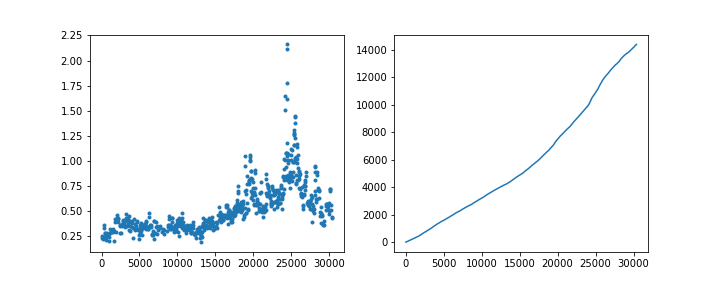

In [393]:

%matplotlib widget
# %matplotlib inline

# plt.plot(age_model[:,0],age_model[:,1])
# plt.plot(np.diff(age_model[:,0]))

invSR_nominal = np.gradient(depth_age_nominal[1], depth_age_nominal[0])
# plt.figure()
fig, axs = plt.subplots(1,2, figsize=(10,4))
axs[0].plot(depth_age_nominal[0], invSR_nominal, '.')
axs[1].plot(depth_age_nominal[0], depth_age_nominal[1])

# plt.plot(depth_age_nominal[1], SR_nominal)

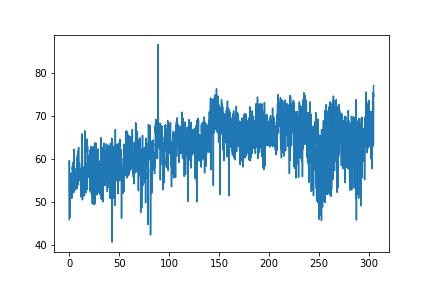

In [43]:
# plt.plot(data_depths)
# plt.plot(np.diff(data_depths[:,0]),  '.')
# plt.plot(data_depths[:,0])
# plt.plot(data_depths[:,1])
# plt.plot(data_depths[:,0], data_depths[:,1])
%matplotlib widget
plt.figure()
plt.plot(data_Lstar[0], data_Lstar[1])

## Preprocessing

In [403]:
# data_Lstar.
depth_data, y_data = data_Lstar
depth_data = depth_data*1e2

In [404]:
depth_lims = np.array([154, 194])*1e2
depth = depth_data[(depth_data>depth_lims[0]) & (depth_data<depth_lims[1])]
y_ori = y_data[(depth_data>depth_lims[0]) & (depth_data<depth_lims[1])]
y_ori = (y_ori-y_ori.mean())/y_ori.std()
depth_original = depth 
lowess = sm.nonparametric.lowess(y_ori, depth, frac=.1).T
y = y_ori - lowess[1]
# depth = (depth - depth[0])/(depth[-1]-depth[0])

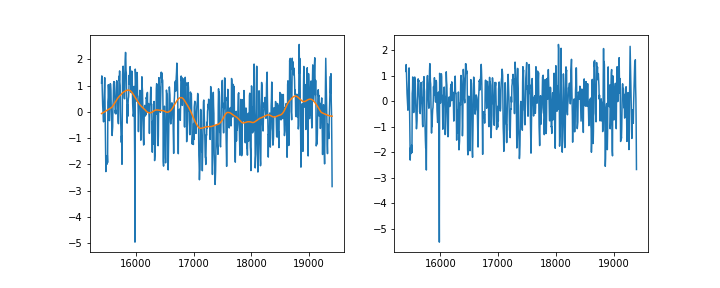

In [405]:
%matplotlib widget
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(depth, y_ori)
plt.plot(lowess[0], lowess[1])
plt.subplot(1,2,2)
plt.plot(depth, y)
# plt.plot(depth, y-lowess[1])

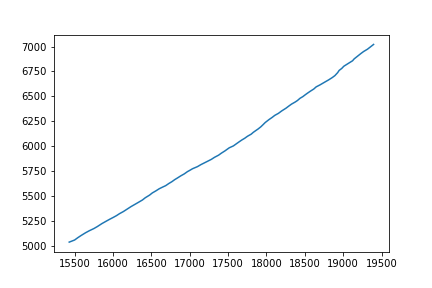

In [406]:
plt.figure()
ind = (depth_age_nominal[0]>depth_lims[0]) & (depth_age_nominal[0]<depth_lims[1])
depth_age = depth_age_nominal[:, ind]
plt.plot(depth_age[0], depth_age[1])

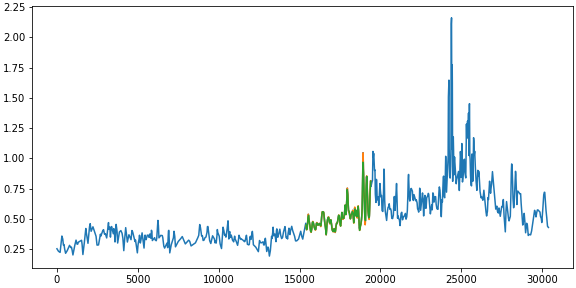

In [407]:
# depth_nominal_interpolate = interpolate_CubicSpline(depth_age_nominal[0], depth)
# time_nominal_interpolate = interpolate_CubicSpline(depth_age_nominal[0], depth)
# invSR_interpo
func_depth_age_nominal = CubicSpline(*depth_age_nominal)
fig, ax = plt.subplots(1,1, constrained_layout=True,figsize=(8,4))
# axs[0].plot(depth, func_depth_age_nominal(depth))
# invSR_nominal = np.gradient(func_depth_age_nominal(depth), depth)

invSR_nominal =  np.gradient(depth_age_nominal[1], depth_age_nominal[0])
func_invSR_nominal = CubicSpline(depth_age_nominal[0], invSR_nominal)
# invSR_nominal = np.gradient(func_depth_age_nominal(depth), depth)

ax.plot(depth_age_nominal[0], invSR_nominal)
ax.plot(depth, func_invSR_nominal(depth))

# axs[1].plot(depth_age_nominal[0], a)
depth_genes = np.linspace(depth_lims[0], depth_lims[1], 100)
ax.plot(depth_genes, func_invSR_nominal(depth_genes))

# Model

In [408]:
coef_time = 1e3


b_k = np.array([0.018986, 0.016354, 0.013055, 0.008849, 0.004248])/0.022 #
muy_k = np.array([4.257564, 7.456665, 17.910194, 17.366595, 5.579378])
phi_k = np.array([30.739, -157.801, 140.577, -55.885, 77.107])
phi_k = phi_k/180/3600*np.pi
muy_k = muy_k/180/3600*np.pi*coef_time

p0 = 50.467718
p0 = p0/180/3600*np.pi*coef_time

# b_k

ordering = [4, 1, 3, 2, 0]
b_k = b_k[ordering]
muy_k = muy_k[ordering]
phi_k = phi_k[ordering]


fe_k = np.array([3.199279, 13.651920, 10.456224, 13.109803, 9.909679])
fe_k = fe_k/180/3600*np.pi*coef_time

fs = np.hstack([muy_k + p0, fe_k])
print(fs)
print(2*np.pi/fs)

[0.27172399 0.28082533 0.32887003 0.33150547 0.26531565 0.01551054
 0.06618638 0.0506932  0.06355812 0.04804348]
[ 23.12341035  22.37399749  19.10537518  18.95348896  23.68192456
 405.09127213  94.93170191 123.94531716  98.85732074 130.78122914]


# Optimize

In [421]:
N_population = 128 # number of individual in population 
N_generations_max = 100
N_genes = 16 # number of intial gene in an individial of the population 
# depth_genes = np.linspace(0,1,N_genes)
depth_genes = np.linspace(depth_lims[0], depth_lims[1], N_genes)
# true_genes = func_inv_SR(depth_genes)
invSR_lims = [0, 2]
# fs = muy_k + p0
fs = np.hstack([muy_k + p0, fe_k])
# fs =  np.array([f1, f2])
# interpolator = interpolate_Akima
interpolator = interpolate_CubicSpline
invSR_to_predx =  partial(invSR_to_pred,  data=[depth, y], invSR_lims=invSR_lims, fs=fs, interpolator=interpolate_CubicSpline)

n_pieces = 2
metric_optimal = metric_piecewise([depth_genes, func_invSR_nominal(depth_genes)], [depth, y], fs, interpolator, n_pieces)
print(metric_optimal)
# invSR_all = np.zeros((N_generations_max, N_population, N_genes))
# invSR_ini = np.random.rand(N_population, N_genes)*invSR_lims[1]
# invSR_all[0] = invSR_ini
# metric_all = np.zeros((N_generations_max, N_population))
# metric_ini = np.array([metric([depth_genes, invSR_ini_i], [depth, y], fs, interpolator, metric_type="BIC") for invSR_ini_i in invSR_ini])
# metric_all[0] = metric_ini
interpolator = interpolate_CubicSpline
data = [depth, y]
problem = invSRinference(depth_genes, invSR_lims, interpolator, data, fs, n_pieces=n_pieces, metric=metric_piecewise)
out = {}
problem._evaluate(np.random.rand(len(depth_genes)), out)
out

[0.1716805  0.12984074]


{'F': array([-0.10298228, -0.05143568])}

## With nominal age model

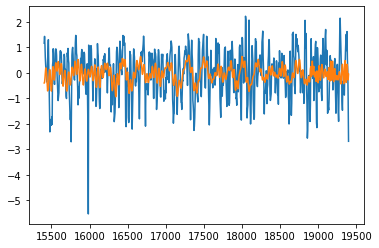

In [422]:
%matplotlib inline
depth_genes_test = np.linspace(depth_lims[0], depth_lims[1], 1000)
invSR_lims = [0, 300]

time, y_pred = invSR_to_predx([depth_genes_test, func_invSR_nominal(depth_genes_test)])
plt.plot(depth, y)
plt.plot(depth, y_pred)


## GA

In [423]:
algorithm = NSGA2(
    pop_size=200,
    n_offsprings=100,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)

termination = get_termination("n_gen", 200)

res = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)

X = res.X
F = res.F

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      200 |      8 |             - |             -
     2 |      300 |      9 |  0.0169588687 |             f
     3 |      400 |      7 |  0.1456455451 |         ideal
     4 |      500 |      5 |  0.1680510137 |         ideal
     5 |      600 |      6 |  0.0106126364 |         ideal
     6 |      700 |      7 |  0.0240635824 |             f
     7 |      800 |      7 |  0.000000E+00 |             f
     8 |      900 |     10 |  0.0318766975 |         ideal
     9 |     1000 |     11 |  0.0170131351 |             f
    10 |     1100 |     12 |  0.1546996190 |         ideal
    11 |     1200 |     12 |  0.0089613557 |             f
    12 |     1300 |     12 |  0.1489866222 |         ideal
    13 |     1400 |     13 |  0.0011048474 |             f
    14 |     1500 |     16 |  0.0231067697 |             f
    15 |     1600 |     15 |  0.0252418729 |             f
    16 |     1700 |     15 |  0.1288378105 |         ide

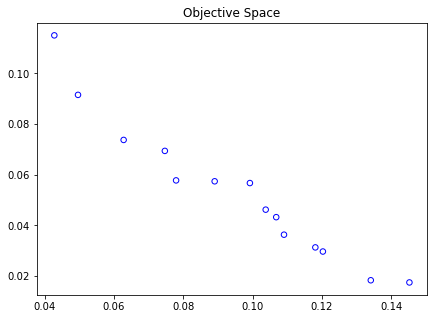

In [418]:
plt.figure(figsize=(7, 5))
plt.scatter(-res.F[:, 0], -res.F[:, 1], s=30, facecolors='none', edgecolors='blue')
f1min, f1max = -res.F[:,0].min(), -res.F[:,0].max()
f1grid = np.linspace(0, 1, 100)

# for i in range(res.F.shape[0]):
#     plt.plot(f1grid, -res.F[i,0] + -res.F[i,1] - f1grid, color="black",alpha=0.5)
plt.title("Objective Space")
# plt.xlim([0,1])
# plt.ylim([0,1])
# plt.plot(metric_optimal[0],metric_optimal[1], "d", color="black")
plt.show()


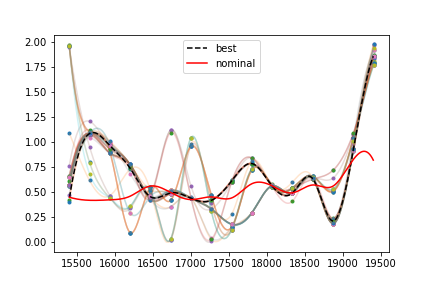

In [424]:
%matplotlib widget
# invSR_interpolate = interpolator([depth_genes, invSR_best], depth)
res.F.shape, res.X.shape
arg_best = np.argmin(res.F.sum(axis=1)/2)
invSR_best = res.X[arg_best]
fig = plt.figure()
for i in range(res.F.shape[0]):
    plt.plot(depth_genes, res.X[i], '.')
    invSR_interpolate = interpolator([depth_genes, res.X[i]], depth)
    invSR_interpolate[invSR_interpolate<invSR_lims[0]] = invSR_lims[0]
    invSR_interpolate[invSR_interpolate>invSR_lims[1]] = invSR_lims[1]
    plt.plot(depth, invSR_interpolate, alpha=0.2)
# plt.plot(depth, invSR, color="red")
plt.plot(depth, interpolator([depth_genes, invSR_best], depth), "--", color="black", label="best")
plt.plot(depth, interpolator([depth_genes, func_invSR_nominal(depth_genes)], depth), color="red", label="nominal")
# invSR_interpolate[invSR_interpolate<0] = 0
plt.legend()
# time = sp.integrate.cumulative_trapezoid(invSR_interpolate, depth, initial=0)
# X = generate_X_linReg(np.ones_like(fs), fs, time)

# reg_model = LinearRegression().fit(X, y_data)
# y_pred = reg_model.predict(X)

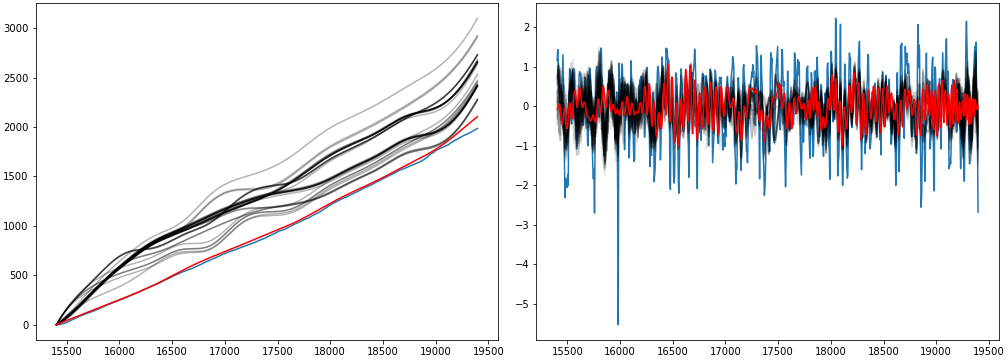

In [425]:
%matplotlib widget
fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(14,5))
axs[1].plot(depth, y)
axs[0].plot(depth_age[0], (depth_age[1]-depth_age[1,0] ))
for i in range(res.F.shape[0]):

    # invSR_interpolate = interpolator([depth_genes, res.X[i]], depth)
    time, y_pred = invSR_to_predx([depth_genes, res.X[i]])
    
    axs[1].plot(depth, y_pred, alpha=0.1, color="black")
    axs[0].plot(depth, time, alpha=0.3, color="black")

time, y_pred = invSR_to_predx([depth_genes, func_invSR_nominal(depth_genes)])
axs[1].plot(depth, y_pred,  color="red")
axs[0].plot(depth, time, color="red")
